In [2]:
import matplotlib
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from plot_utils import *

In [5]:
from dataset import *

transform = Reshape2DField()

datasets = {
    'cad': AtlasDataset('WT', 'ECad-GFP', 'tensor2D', transform=transform),
    'cvel': AtlasDataset('WT', 'ECad-GFP', 'velocity2D', transform=transform),
    'sqh': AtlasDataset('WT', 'sqh-mCherry', 'tensor2D', transform=transform),
    'runt': AtlasDataset('WT', 'Runt', 'raw2D', transform=transform)
}

100%|██████████| 6/6 [00:00<00:00, 247.25it/s]


In [26]:
datasets['cvel'].df.time.unique()

array([-1.884, -0.884,  0.116,  1.116,  2.116,  3.116,  4.116,  5.116,
        6.116,  7.116,  8.116,  9.116, 10.116, 11.116, 12.116, 13.116,
       14.116, 15.116, 16.116, 17.116, 18.116, 19.116, 20.116, 21.116,
       22.116, 23.116, 24.116, 25.116, 26.116, 27.116, 28.116, 29.116,
       30.116, 31.116, 32.116, 33.116, 34.116, 35.116, 36.116, 37.116,
       38.116, 39.116, 40.116, 41.116, 42.116, 43.116, 44.116, 45.116,
       46.116, 47.116, 48.116, 49.116, 50.116, 51.116, 52.116, 53.116,
       54.116, 55.116, 56.116, 57.116, 58.116, 59.116, 60.116, 61.116,
       62.116, 63.116, 64.116, 65.116, 66.116, 67.116, 68.116, 69.116,
       70.116, 71.116, 72.116, 73.116, 74.116, 75.116, 76.116, 77.116,
       78.116, 79.116, 80.116, 81.116, 82.116, 83.116, 84.116, 85.116,
       86.116, 87.116, 88.116, 89.116, 90.116, 91.116, 92.116])

In [10]:
datasets['cad'].df.embryoID.unique()

array([202001280915, 202001282000, 202001271040, 202001261800,
       202001281430, 202001281800])

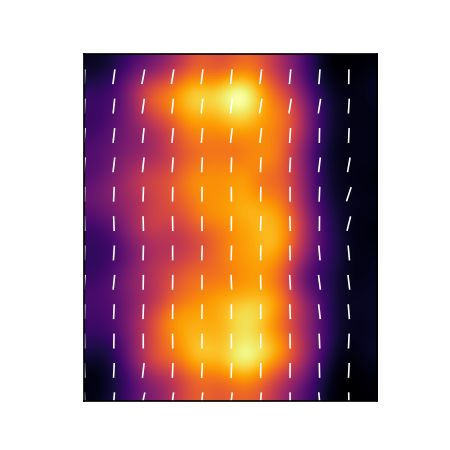

In [61]:
%matplotlib widget

plt.rcParams['font.size'] = 6
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

'''
Set up plots
'''
import ipywidgets as ipw

output = ipw.Output()
with output:
    fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)
    
dataset_select = ipw.Dropdown(
    options=datasets,
    description='Dataset',
)

df = dataset_select.value.df
embryo_select = ipw.Dropdown(
    options=df.embryoID.unique(),
    description='Embryo',
    continuous_update=False,
)

ekey = embryo_select.value
time_select = ipw.FloatSlider(
    min=df.loc[df.embryoID==ekey, 'time'].min(),
    max=df.loc[df.embryoID==ekey, 'time'].max(),
    description='Time',
)

def update_embryo(_):
    df = dataset_select.value.df
    options = df.embryoID.unique()
    embryo_select.options = options
    embryo_select.value = options[0]
    update_time(None)
    
def update_time(_):
    global vmin, vmax
    df = dataset_select.value.df
    ekey = embryo_select.value
    
    data = dataset_select.value.values[ekey]
    data = data.reshape([data.shape[0], -1, *data.shape[-2:]])
    data = np.linalg.norm(data, axis=1)
    vmin = np.min(data)
    vmax = np.max(data)
    
    time_select.min = df.loc[df.embryoID==ekey, 'time'].min()
    time_select.max = df.loc[df.embryoID==ekey, 'time'].max()
    time_select.value = time_select.min
    update_plot(None)

def update_plot(_):
    dataset = dataset_select.value
    ekey = embryo_select.value
    time = time_select.value
    
    df = dataset.df[dataset.df.embryoID == ekey]
    row = (df['time']-time).abs().argmin()
    idx = df.iloc[row].name
    data = dataset[idx]['value']
    
    ax.clear()
    if data.shape[0] == 1:
        color_2D(ax, data, vmin=vmin, vmax=vmax)
    elif data.shape[0] == 2:
        plot_vector2D(ax, data, vmin=vmin, vmax=vmax)
    elif data.shape[0] == 4:
        plot_tensor2D(ax, data)
    
dataset_select.observe(update_embryo, names=['value'])
embryo_select.observe(update_time, names=['value'])
time_select.observe(update_plot, names=['value'])
update_embryo(None)

control = ipw.VBox([
    dataset_select,
    embryo_select,
    time_select
])
display(ipw.VBox([control, output]))